{'api-version': '2024-02-01', 'features': 'objects,caption,denseCaptions,tags,smartCrops', 'gender-neutral-caption': False}
objectsResult
denseCaptionsResult
smartCropsResult


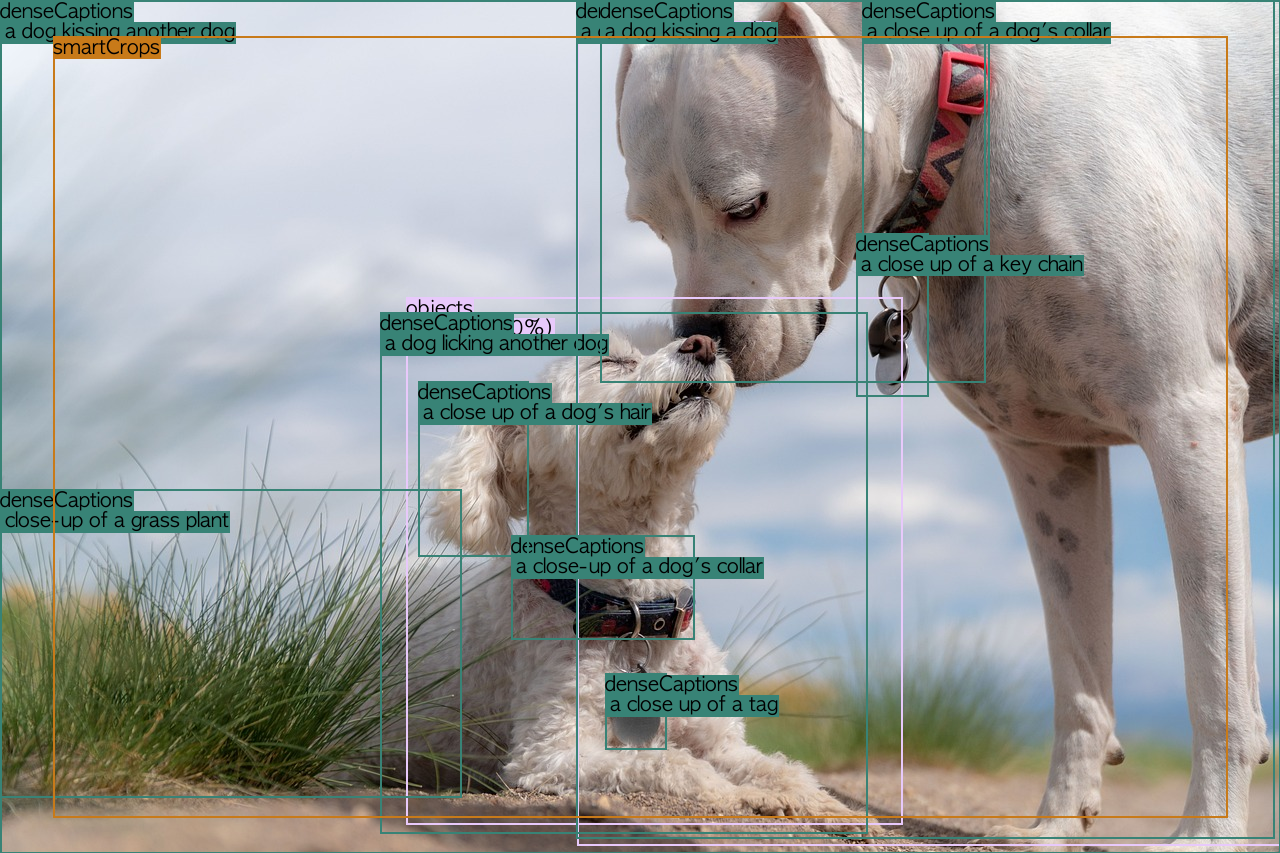

In [1]:
import requests
from PIL import Image, ImageDraw
from io import BytesIO


IMAGE_URL = "https://cdn.pixabay.com/photo/2019/08/25/13/34/dogs-4429513_1280.jpg"
BASE_ENDPOINT = "https://7ai053-vision.cognitiveservices.azure.com/computervision/imageanalysis:analyze/"
API_KEY="2ULu8XTGf4EqMsxTeODbTBrFsPeSxbe3FluLoMsWqau8bWP8bIZTJQQJ99BGACYeBjFXJ3w3AAAFACOGYQSC"


def random_color():
    import random
    # 랜덤한 RGB 색상 튜플 반환
    import random
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) 


def get_font():
    # OS별로 적절한 폰트 객체 반환 (한글 지원)
    from PIL import ImageFont
    import platform
    
    font_size = 20
    
    try:
        if platform.system() == "Windows":
            return ImageFont.truetype("malgun.ttf", font_size)
        elif platform.system() == "Darwin":  # macOS
            return ImageFont.truetype("AppleGothic.ttf", font_size)
        else:  # Linux      
            return ImageFont.load_default(size=font_size)
    except IOError:
        # 폰트 파일이 없을 경우 기본 폰트 사용
        return ImageFont.load_default(size=font_size)
    
# features에 따라 response가 변함
# features가 caption일 때 gender-neutral-caption을 추가해줘야 한다. 아예 빠지던지, 추가되던지 해야함.
# features smartCorps 일 때, smart-aspect-ratios 를 추가해야한다. 단, 빈값도 가능.

def request_image_analysis(image_url,features=['objects'],**kwargs):
    endpoint="{}".format(BASE_ENDPOINT)
    """
    api-version=2024-02-01&features=caption&gender-neutral-caption=true
    """
    params={
        "api-version":"2024-02-01",
        "features":",".join(features)
    }
    headers={
        "Ocp-Apim-Subscription-Key":API_KEY
    }
    body={
        "url":IMAGE_URL   
    }

    if kwargs is not None:
        if ("caption" in features or "danseCaptions" in features) and "gender_neutral_caption" in kwargs.keys():
            params.update({
                "gender-neutral-caption":kwargs['gender_neutral_caption']
            })
        if "smartcrops" in features and "smartcrops_aspect_ratios" in kwargs.keys():
            params.update({
                "smartcrops-aspect-ratios":kwargs['smartcrops_aspect_ratios']
            })

        print(params)

        response=requests.post(endpoint,params=params,headers=headers,json=body)

        if response.status_code !=200:
            return None
        
        response_json=response.json()
        return response_json



def draw_image(IMAGE_URL, features, data):
    # 이미지 다운로드
    image_response = requests.get(IMAGE_URL)
    image = Image.open(BytesIO(image_response.content))
    draw = ImageDraw.Draw(image)
    font = get_font()

    for feature in features:
        if feature == "tags" or feature == "caption":
            continue
        feature_key = '{}Result'.format(feature)
        print(feature_key)
        # 객체인식 결과 리스트
        result_object = data[feature_key]
        block_list = result_object['values']

        color = random_color()

        for block in block_list:

            bounding_box = block['boundingBox']
            x, y, w, h = bounding_box['x'], bounding_box['y'], bounding_box['w'], bounding_box['h']

            if feature == "objects":
                tag = block['tags'][0]       
                name = tag['name']
                confidence = tag['confidence']
                
                formatted_text = "{} ({:.2f}%)".format(name, confidence * 100)
            
            elif feature == "denseCaptions":
                formatted_text = block["text"]
            else:
                formatted_text=None
            
            # 객체 위치에 사각형과 라벨 그리기
            draw.rectangle([(x, y), (x + w, y + h)], outline=color, width=2)

            # Feature의 텍스트를 그려주는 부분
            feature_text_bbox=draw.textbbox((x, y),feature, font=font)
            draw.rectangle([(feature_text_bbox[0],feature_text_bbox[1]),(feature_text_bbox[2]),(feature_text_bbox[3])],outline=color,fill=color,width=2)
            draw.text((x,y),feature,fill="black",font=font)

            # 텍스트를 그려주는 부분
            if formatted_text:
                text_bbox=draw.textbbox((x,y+20),formatted_text,font=font)
                draw.rectangle([(text_bbox[0],text_bbox[1]),(text_bbox[2]+5,text_bbox[3])],outline=color,fill=color,width=2)
                draw.text((x+5,y+20),formatted_text,fill="black",font=font)
        
    return image

# 객체 인식 결과 요청 및 시각화
features=["objects","caption","denseCaptions","tags","smartCrops"]
response_json2 = request_image_analysis(IMAGE_URL,features,gender_neutral_caption=False,smartcrops_aspect_ratios="0.7,1.8")
draw_image(IMAGE_URL,features,response_json2)


In [2]:
response_json2


{'modelVersion': '2023-10-01',
 'captionResult': {'text': 'a dog kissing another dog',
  'confidence': 0.7410182356834412},
 'denseCaptionsResult': {'values': [{'text': 'a dog kissing another dog',
    'confidence': 0.7410182356834412,
    'boundingBox': {'x': 0, 'y': 0, 'w': 1280, 'h': 853}},
   {'text': 'a dog licking another dog',
    'confidence': 0.792608380317688,
    'boundingBox': {'x': 380, 'y': 312, 'w': 487, 'h': 521}},
   {'text': 'a dog sniffing a dog',
    'confidence': 0.6485675573348999,
    'boundingBox': {'x': 576, 'y': 0, 'w': 698, 'h': 838}},
   {'text': "a close-up of a dog's collar",
    'confidence': 0.8483867049217224,
    'boundingBox': {'x': 511, 'y': 535, 'w': 183, 'h': 104}},
   {'text': 'a close up of a tag',
    'confidence': 0.809928834438324,
    'boundingBox': {'x': 605, 'y': 673, 'w': 61, 'h': 76}},
   {'text': 'close-up of a grass plant',
    'confidence': 0.7018072605133057,
    'boundingBox': {'x': 0, 'y': 489, 'w': 461, 'h': 308}},
   {'text': "a c

In [3]:
print(features)

['objects', 'caption', 'denseCaptions', 'tags', 'smartCrops']


##가변인자(kwargs) 이해하기


In [4]:
def aa(**kwargs):
    print(kwargs)

aa(a=1,b=2, c=3)

{'a': 1, 'b': 2, 'c': 3}


In [5]:
def greet(name, **kwargs):
    greeting = kwargs.get('greeting', '안녕하세요')  # greeting 옵션, 기본값 '안녕하세요'
    punctuation = kwargs.get('punctuation', '!')    # 문장부호 옵션, 기본값 '!'
    print(f"{greeting}, {name}{punctuation}")

# 함수 호출 예시
greet("으나")                          # 안녕하세요, 으나!
greet("으나", greeting="반갑습니다")     # 반갑습니다, 으나!
greet("으나", punctuation="!!!")       # 안녕하세요, 으나!!!
greet("으나", greeting="잘 지내세요", punctuation="~")  # 잘 지내세요, 으나~


안녕하세요, 으나!
반갑습니다, 으나!
안녕하세요, 으나!!!
잘 지내세요, 으나~
